In [132]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import skimage.draw
import collections

In [ ]:
#128
#141 

In [560]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [833]:
path = '/home/maxim/cycle_gan/pytorch-CycleGAN-and-pix2pix/datasets/cityscapes/'

In [1173]:
im1 = cv2.cvtColor(cv2.imread(path+'128BtoA_input_real_A.png'), cv2.COLOR_BGR2RGB).astype('double')/255
im2 = cv2.cvtColor(cv2.imread(path+'141BtoA_input_real_A.png'), cv2.COLOR_BGR2RGB).astype('double')/255

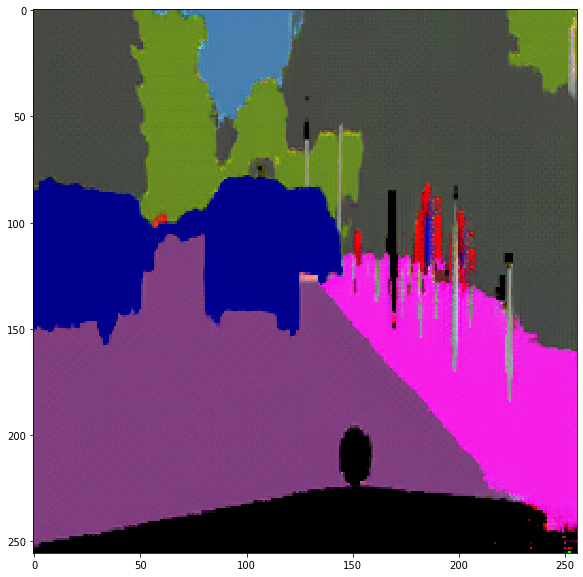

In [1108]:
%matplotlib inline
plt.subplots(figsize=(10,10))
plt.imshow(im1)

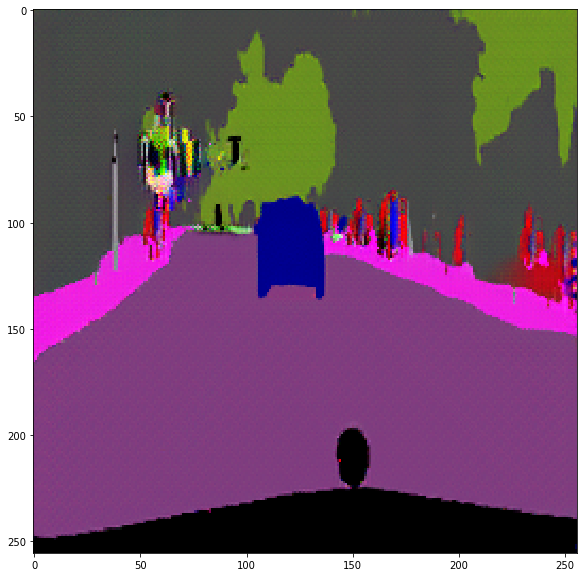

In [1109]:
plt.subplots(figsize=(15,10))
plt.imshow(im2)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


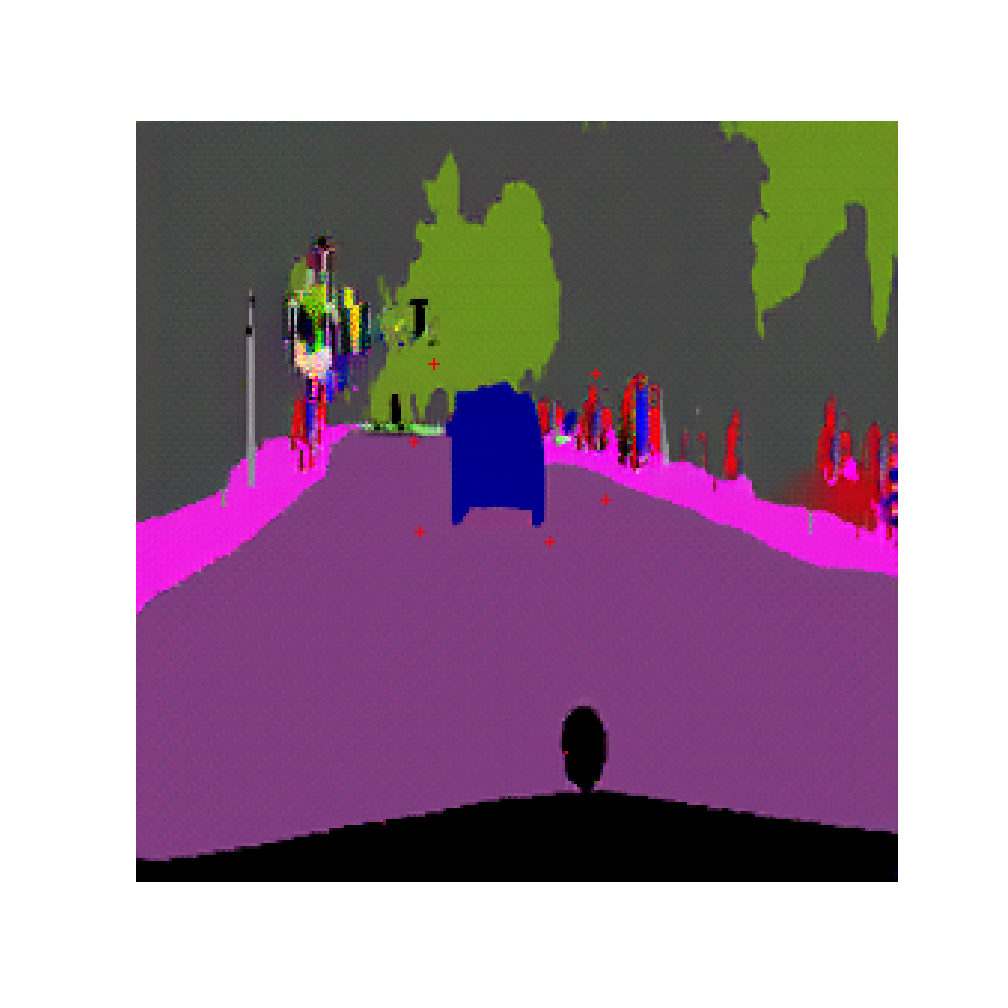

In [1111]:
from utils import specify_mask
%matplotlib notebook
a = specify_mask(im2)

In [1076]:
%matplotlib inline
print(a)

[[96.28378600336382, 1.4241202827709358, 2.769647456112679, 91.57444089666771], [198.92057825475663, 203.62992336145274, 75.80484189398717, 77.82313265399978], [96.28378600336382, 1.4241202827709358, 2.769647456112679, 91.57444089666771], [198.92057825475663, 203.62992336145274, 75.80484189398717, 77.82313265399978]]


(256, 256, 3)


<IPython.core.display.Javascript object>


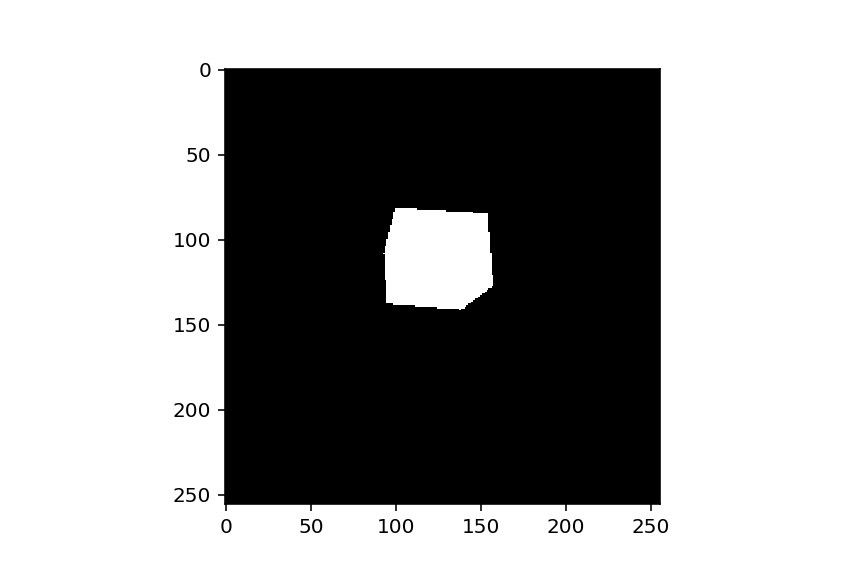

In [1112]:
#https://scikit-image.org/docs/dev/api/skimage.draw.html#skimage.draw.polygon2mask
import skimage.draw
image_shape = im1.shape
print(image_shape)
rr, cc = skimage.draw.polygon(a[1],a[0])
img = np.zeros(image_shape)
img[rr, cc] = 1
plt.imshow(img)
masked_im1 = img * im2
masked_im1_mask = masked_im1 > 0
coords = np.argwhere(masked_im1_mask)
min_y, max_y = np.min(coords[:,0]), np.max(coords[:,0])
min_x, max_x = np.min(coords[:,1]), np.max(coords[:,1])
box_coords = [(min_x, min_y), (min_x, max_y), (max_x, min_y), (max_x, max_y)]
new_img = masked_im1[min_y:max_y,min_x:max_x,:]

<IPython.core.display.Javascript object>


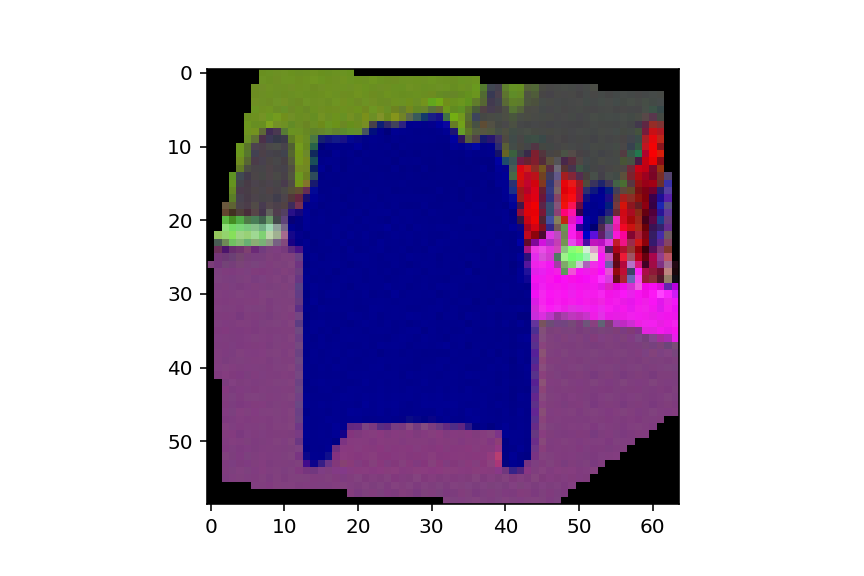

In [1113]:
plt.imshow(new_img)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


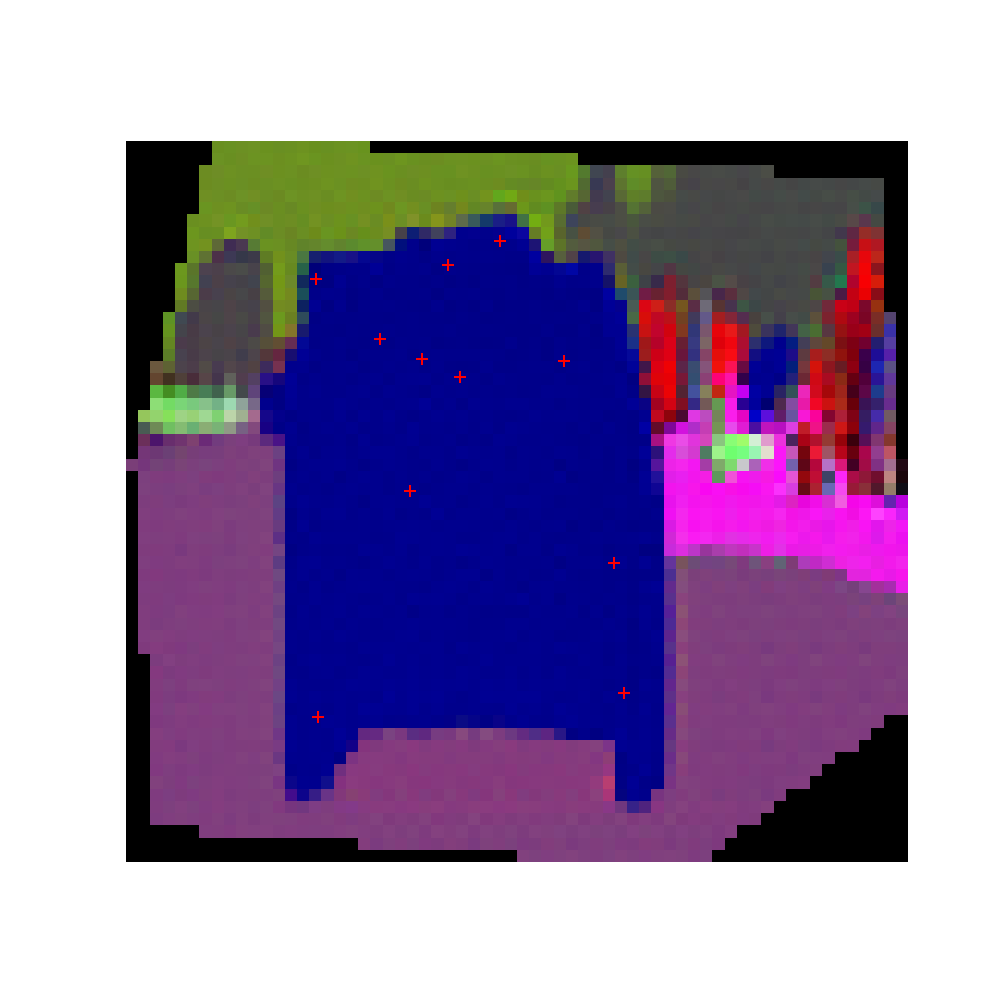

In [1114]:
%matplotlib notebook
correct_colors_coords = specify_mask(new_img)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


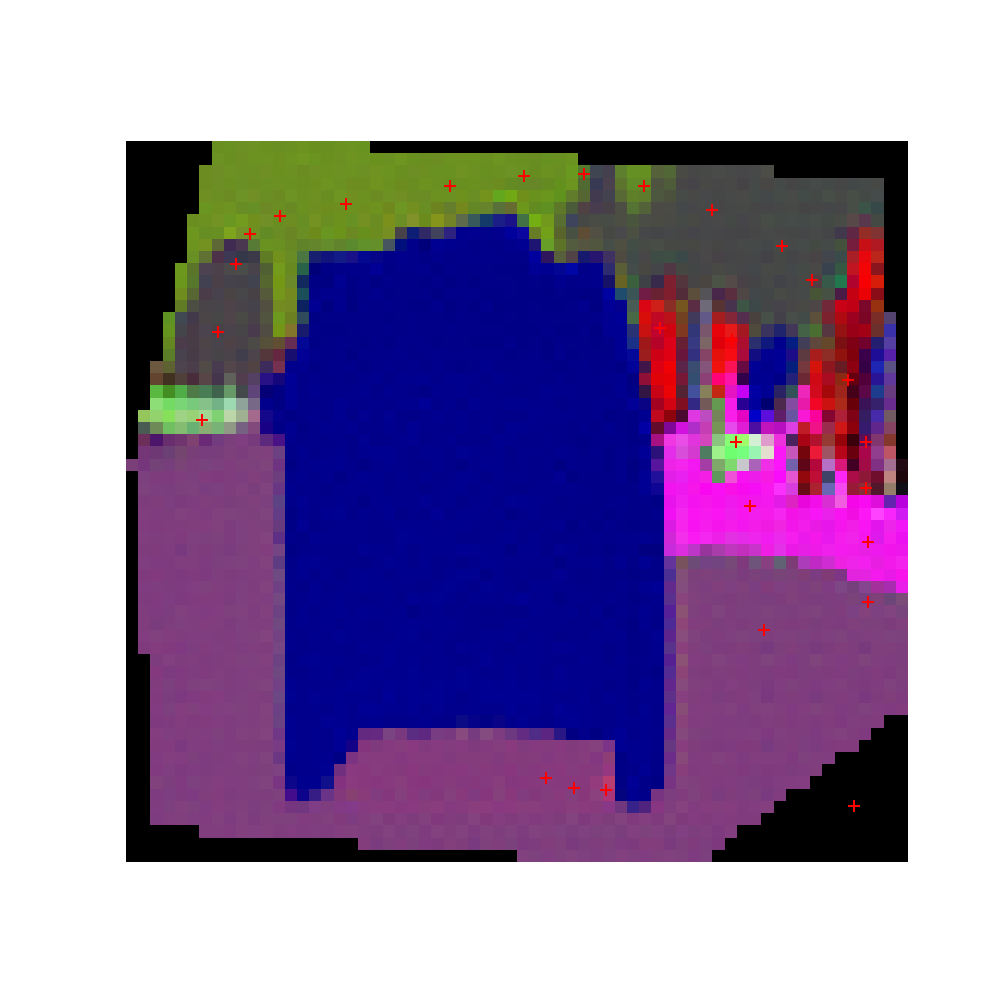

In [1115]:
%matplotlib notebook
incorrect_colors_coords = specify_mask(new_img)

In [1116]:
%matplotlib inline

In [1117]:
colors = []
for i in range(len(correct_colors_coords[0])):
    colors.append(new_img[int(correct_colors_coords[1][i]), int(correct_colors_coords[0][i])])
colors = np.array(colors, dtype=np.float32)

In [1118]:
incorrect_colors = []
for i in range(len(incorrect_colors_coords[0])):
    incorrect_colors.append(new_img[int(incorrect_colors_coords[1][i]), int(incorrect_colors_coords[0][i])])
incorrect_colors = np.array(incorrect_colors, dtype=np.float32)

In [1119]:
X = np.concatenate((colors, incorrect_colors), axis=0)
y = np.concatenate((np.ones(len(colors)),np.zeros(len(incorrect_colors))))
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [1120]:
flat_img = new_img.reshape(-1,3)
predicted = neigh.predict(flat_img)

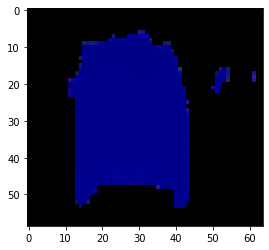

In [1121]:
predicted_mask = predicted.reshape(new_img.shape[:2])
predicted_mask = np.dstack((predicted_mask,predicted_mask,predicted_mask))
predicted_img = predicted_mask * new_img
plt.imshow(predicted_img)

In [1088]:
predicted_mask.shape

(127, 94, 3)

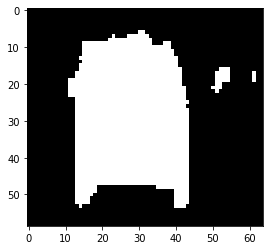

In [1122]:
plt.imshow(predicted_mask)

In [1123]:
# visits all the nodes of a graph (connected component) using BFS
def get_neighbours(img, node):
    img_shape = img.shape
    #neighbors = [(node[0]-1,node[1]-1),(node[0]-1,node[1]),(node[0]-1,node[1]+1),(node[0],node[1]-1),\
     #           (node[0],node[1]+1),(node[0]+1,node[1]-1),(node[0]+1,node[1]),(node[0]+1,node[1]+1)]
    neighbors = [(node[0]-1,node[1]),(node[0],node[1]-1),\
            (node[0],node[1]+1),(node[0]+1,node[1])]
    checked = []
    
    for coords in neighbors:
        if (coords[0] >=0 and coords[0] < img_shape[0]) and (coords[1] >= 0 and coords[1] < img_shape[1]):
            checked.append(coords)
    return checked

In [1124]:
def bfs_perf_connected_component(img, start):   
    explored = set()
    good = set()
    # keep track of nodes to be checked
    queue = collections.deque([start])
    # keep looping until there are nodes still to be checked
    temp = []
    while queue:
        # pop shallowest node (first node) from queue
        node = queue.popleft()
        #print(node)
        if node not in explored:
            # add node to list of checked nodes
            explored.add(node)
            if img[node] == 1 and node not in good:
                good.add(node)
            neighbours = get_neighbours(img, node)
            # add neighbours of node to queue
            for neighbour in neighbours:
                if img[neighbour] == 1:
                    queue.append(neighbour)
    return list(good), temp

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


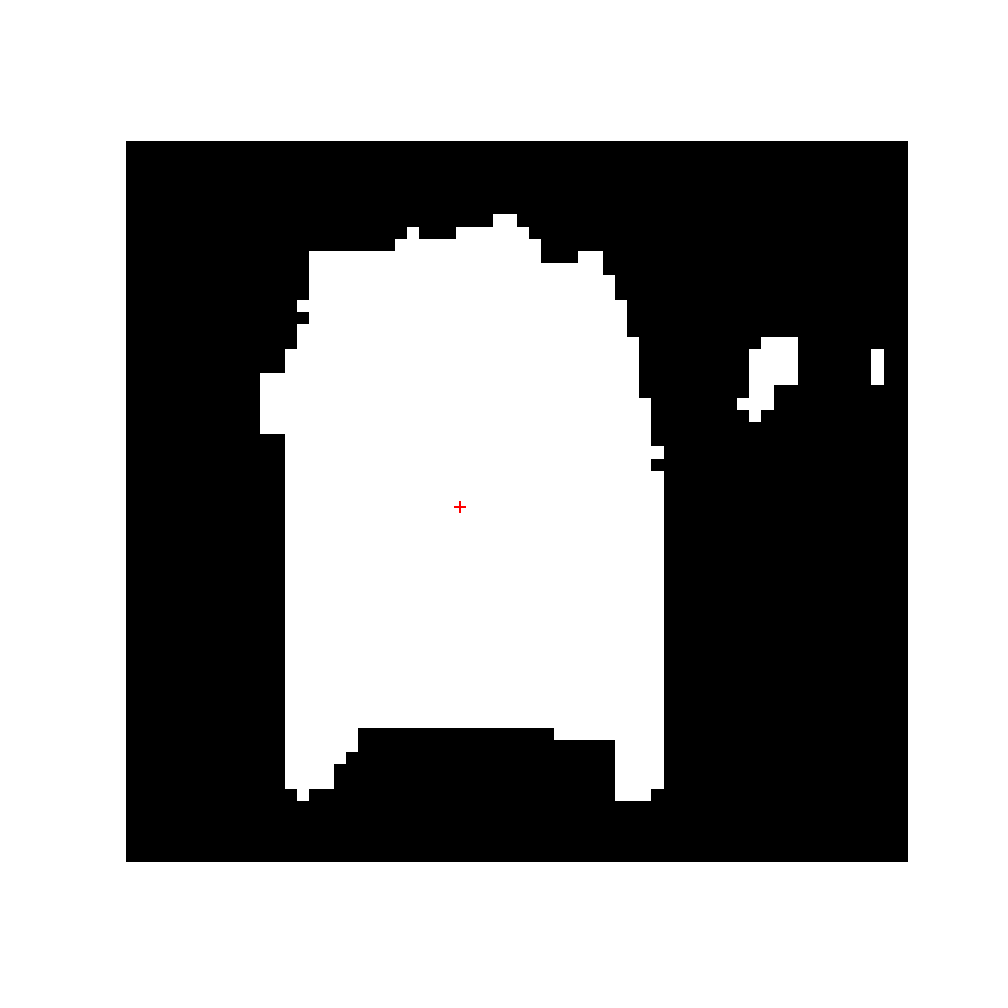

In [1125]:
%matplotlib notebook
start_coords = specify_mask(predicted_mask)

In [1093]:
%matplotlib inline

In [1126]:
start = (int(start_coords[1][0]),int(start_coords[0][0]))
print(start)
cut1, temp = bfs_perf_connected_component(predicted_mask[:,:,0], start)

(29, 26)


<IPython.core.display.Javascript object>


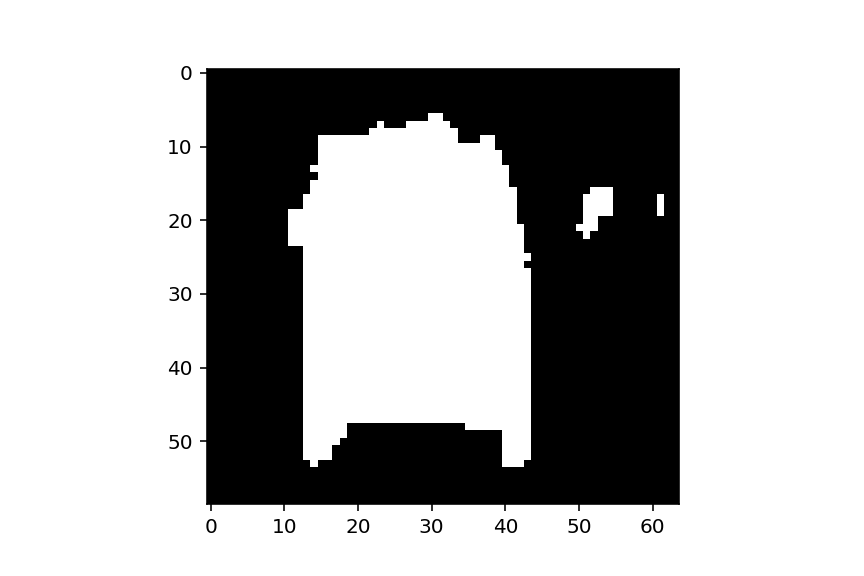

In [1127]:
plt.imshow(predicted_mask)

In [1128]:
empty = np.zeros(im2.shape)
for i in cut1:
    empty[i] = predicted_img[i]

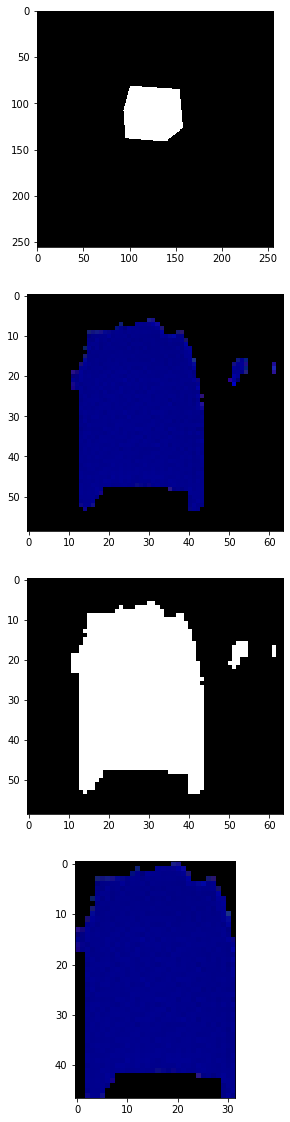

In [1130]:
%matplotlib inline
fig, ax = plt.subplots(4,1, figsize=(15,20))
masked_im1 = empty
masked_im1_mask = masked_im1 > 0
coords = np.argwhere(masked_im1_mask)
min_y, max_y = np.min(coords[:,0]), np.max(coords[:,0])
min_x, max_x = np.min(coords[:,1]), np.max(coords[:,1])
box_coords = [(min_x, min_y), (min_x, max_y), (max_x, min_y), (max_x, max_y)]
patch_img = masked_im1[min_y:max_y,min_x:max_x,:]
patch_img_shape = patch_img.shape
ax[0].imshow(img)
ax[1].imshow(predicted_img)
ax[2].imshow(predicted_mask)
ax[3].imshow(patch_img)

In [989]:
# masked_im1 = predicted_img
# masked_im1_mask = masked_im1 > 0
# coords = np.argwhere(masked_im1_mask)
# min_y, max_y = np.min(coords[:,0]), np.max(coords[:,0])
# min_x, max_x = np.min(coords[:,1]), np.max(coords[:,1])
# box_coords = [(min_x, min_y), (min_x, max_y), (max_x, min_y), (max_x, max_y)]
# patch_img = masked_im1[min_y:max_y,min_x:max_x,:]
# patch_img_shape = patch_img.shape

<IPython.core.display.Javascript object>


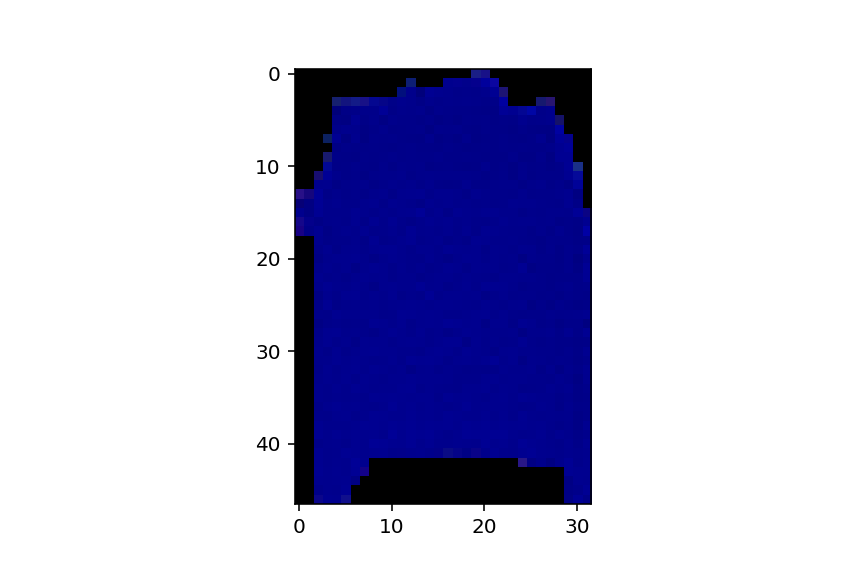

In [1146]:
plt.imshow(patch_img)

In [1145]:
patch_img_shape

(47, 32, 3)

In [1171]:
def specify_center(img, patch_img):
    print("If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash")
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    myobj = ax.imshow(img, cmap='gray')
    fig.set_label('Choose target bottom-center location')
    plt.axis('off')
    target_loc = np.zeros(2, dtype=int)

    def on_mouse_pressed(event):
        target_loc[0] = int(event.xdata)
        target_loc[1] = int(event.ydata)
        ax.plot(target_loc[0], target_loc[1], 'r+')
        overlay(img, patch_img)
    
    def overlay(img, patch_img):
        patch_img_shape = patch_img.shape
        x_min= target_loc[1]-int(patch_img_shape[0]/2)
        x_max = target_loc[1]+int(patch_img_shape[0]/2)+(patch_img_shape[0]-(bottom[1]+int(patch_img_shape[0]/2)-x_min))
        y_min = target_loc[0]-int(patch_img_shape[1]/2)
        y_max = target_loc[0]+int(patch_img_shape[1]/2)+ (patch_img_shape[1]-(bottom[0]+int(patch_img_shape[1]/2)-y_min))
        temp = np.zeros(im1.shape)
        temp[x_min:x_max,y_min:y_max,:] = patch_img
        temp_mask0 = temp[:,:,0] > 0
        temp_mask1 = temp[:,:,1] > 0
        temp_mask2 = temp[:,:,2] > 0
        temp_mask = np.logical_or(temp_mask0, (np.logical_or(temp_mask1, temp_mask2)))
        im_new = img
        im_new[temp_mask] = temp[temp_mask]
        img = im_new
        myobj.set_data(im_new)
        ax.imshow(im_new)
        plt.draw()
        plt.show()
        
    cid = fig.canvas.mpl_connect('button_press_event', on_mouse_pressed)
    return target_loc, img

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


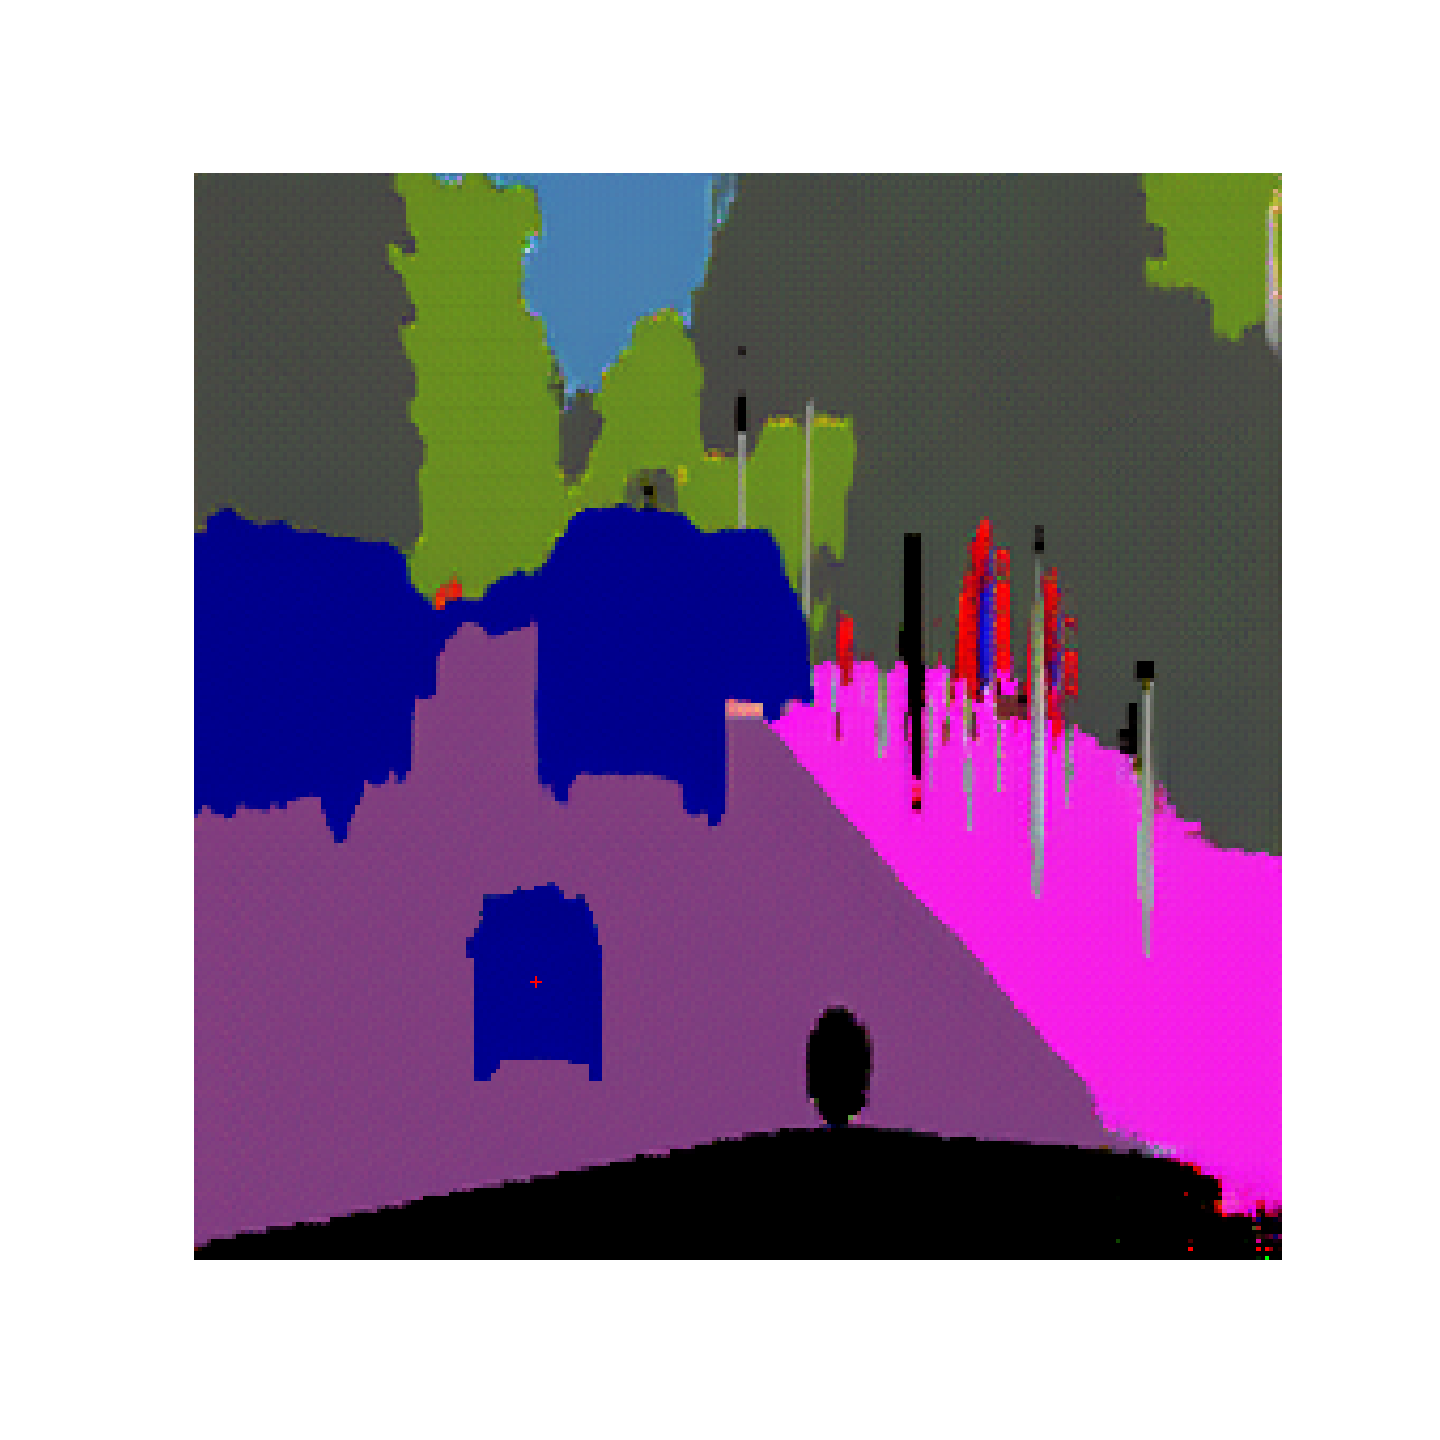

In [1174]:
%matplotlib notebook
bottom, im_created = specify_center(im1, patch_img)

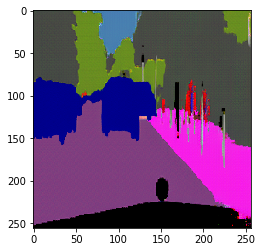

In [1153]:
%matplotlib inline
plt.imshow(im_created)
#im_created = 0

In [1170]:
patch_img_shape = patch_img.shape
x_min= bottom[1]-int(patch_img_shape[0]/2)
x_max = bottom[1]+int(patch_img_shape[0]/2) + (patch_img_shape[0]-(bottom[1]+int(patch_img_shape[0]/2)-x_min))
y_min = bottom[0]-int(patch_img_shape[1]/2)
y_max = bottom[0]+int(patch_img_shape[1]/2) + (patch_img_shape[1]-(bottom[0]+int(patch_img_shape[1]/2)-y_min))
temp = np.zeros(im1.shape)
temp[x_min:x_max,y_min:y_max,:] = patch_img
temp_mask0 = temp[:,:,0] > 0
temp_mask1 = temp[:,:,1] > 0
temp_mask2 = temp[:,:,2] > 0
temp_mask = np.logical_or(temp_mask0, (np.logical_or(temp_mask1, temp_mask2)))
im_new = im1
im_new[temp_mask] = temp[temp_mask]

In [1157]:
plt.imsave(save_path+'merged_bigcaronside.png', im_created)